In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evoman.environment import Environment
from controller_custom import player_controller
# from evoman.controller import Controller
from multiprocessing import Pool
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd
import warnings

pygame 2.6.0 (SDL 2.28.4, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
results_EA1_EG1 = pd.read_csv('results\\results_EA1_EG1.csv')
results_EA2_EG1 = pd.read_csv('results\\results_EA2_EG1_v2.csv')
results_EA1_EG2 = pd.read_csv('results\\results_EA1_EG2.csv')
results_EA2_EG2 = pd.read_csv('results\\results_EA2_EG2_v3.csv')

# Do the same here for group 2

In [4]:
# Concatenate dataframes (stack them)
results_group1 = pd.concat([results_EA1_EG1, results_EA2_EG1])
results_group2 = pd.concat([results_EA1_EG2, results_EA2_EG2])
results_all = pd.concat([results_group1, results_group2])

In [5]:
results_all

,Algorithm,Enemy Group,Run,Generation,Mean Fitness,Max Fitness,Best Solution
0,A,1,1,0,-3.439859,21.508035,[-0.1403258 0.12566047 -0.98774271 0.218824...
1,A,1,1,1,-0.478503,30.328724,[-0.1403258 0.12566047 -0.98774271 0.218824...
2,A,1,1,2,2.079458,42.692015,[-0.1403258 0.12566047 -0.98774271 0.218824...
3,A,1,1,3,3.460673,42.692015,[-0.1403258 0.12566047 -0.98774271 0.218824...
4,A,1,1,4,5.825666,46.580940,[-0.1403258 0.12566047 -0.98774271 0.218824...
...,...,...,...,...,...,...,...
495,B,2,10,45,70.609300,74.923685,[-9.24946047e-01 3.88568294e-01 9.74287146e-...
496,B,2,10,46,70.637482,74.923685,[-9.24946047e-01 3.88568294e-01 9.74287146e-...
497,B,2,10,47,70.710736,74.923685,[-9.24946047e-01 3.88568294e-01 9.74287146e-...
498,B,2,10,48,70.832864,74.923685,[-9.24946047e-01 3.88568294e-01 9.74287146e-...


In [6]:
# Group by Algorithm, Enemy, Generation and compute mean and std
grouped = results_all.groupby(['Algorithm', 'Enemy Group', 'Generation']).agg(
    mean_fitness_mean=('Mean Fitness', 'mean'),
    mean_fitness_std=('Mean Fitness', 'std'),
    max_fitness_mean=('Max Fitness', 'mean'),
    max_fitness_std=('Max Fitness', 'std'),
).reset_index()

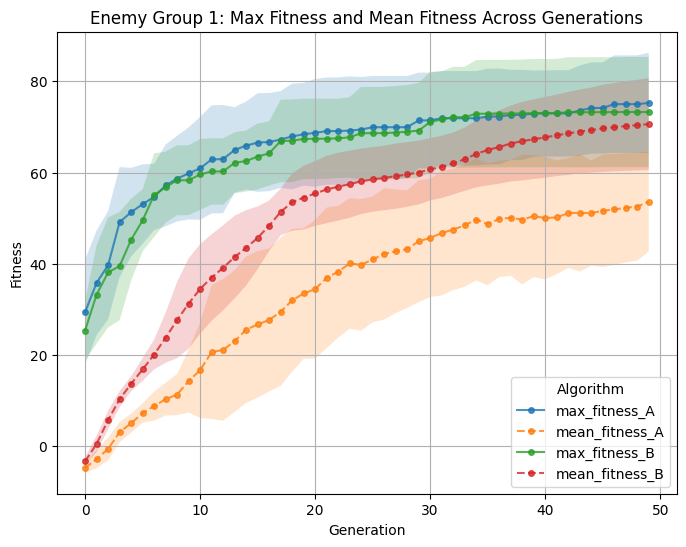

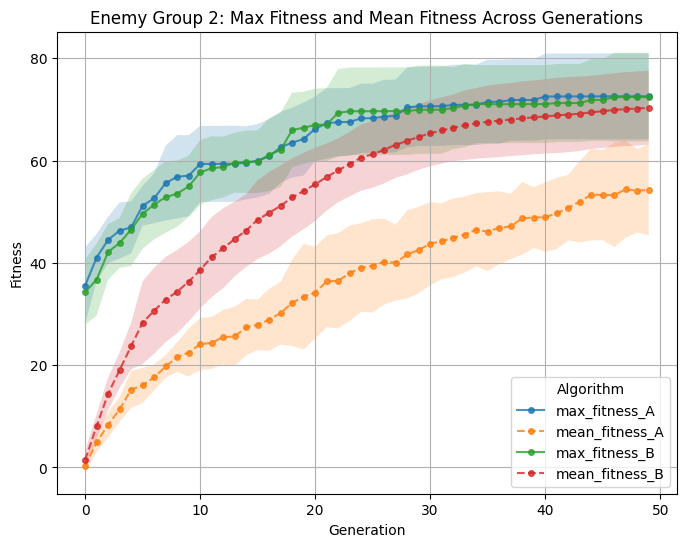

In [7]:
enemy_groups = [1,2]
for enemy_group in enemy_groups:
    plt.figure(figsize=(8, 6))
    data_enemy = grouped[grouped['Enemy Group'] == enemy_group]

    algorithms = data_enemy['Algorithm'].unique()

    for algorithm in algorithms:
        data_alg = data_enemy[data_enemy['Algorithm'] == algorithm]

        # Max Fitness
        plt.plot(
            data_alg['Generation'], 
            data_alg['max_fitness_mean'], 
            label=f'max_fitness_{algorithm}', 
            marker='o',
            markersize=4,
            alpha = 0.8
        )
        # Max Fitness Std
        plt.fill_between(
            data_alg['Generation'],
            data_alg['max_fitness_mean'] - data_alg['max_fitness_std'],
            data_alg['max_fitness_mean'] + data_alg['max_fitness_std'],
            alpha=0.2
        )
        
        # Mean Fitness
        plt.plot(
            data_alg['Generation'], 
            data_alg['mean_fitness_mean'], 
            label=f'mean_fitness_{algorithm}', 
            marker='o', 
            linestyle='--',
            markersize=4,
            alpha = 0.8
        )

        # Mean Fitness Std
        plt.fill_between(
            data_alg['Generation'],
            data_alg['mean_fitness_mean'] - data_alg['mean_fitness_std'],
            data_alg['mean_fitness_mean'] + data_alg['mean_fitness_std'],
            alpha=0.2
        )

    plt.title(f'Enemy Group {enemy_group}: Max Fitness and Mean Fitness Across Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.grid()
    plt.legend(title='Algorithm')

    plt.show()

In [8]:
def parse_solution_string(solution_string):
    cleaned_string = solution_string.replace('[', '').replace(']', '').replace(',', ' ')
    return list(map(float, cleaned_string.split()))


In [9]:
def calculate_gain(solution, enemy_group, experiment_name, n_hidden_neurons, num_tests=5):
    # Create the directory if it does not exist
    os.makedirs(experiment_name, exist_ok=True)
    solution = np.array(solution)
    
    env = Environment(
        experiment_name=experiment_name,
        enemies=enemy_group,
        playermode="ai",
        multiplemode="yes",
        player_controller=player_controller(n_hidden_neurons),
        enemymode="static",
        level=2,
        speed="fastest",
        visuals=False
    )
    
    gains = []
    for _ in range(num_tests):
            # Initialize the environment
        num_sensors = env.get_num_sensors()
        env.player_controller.set(solution, num_sensors)
        f, p_e, e_e, _ = env.play(pcont=solution)
        gain = p_e - e_e
        print(f'Gain: {gain:.4f}')
        gains.append(gain)
    
    return np.mean(gains)


In [10]:
results_all['Best Solution'] = results_all['Best Solution'].apply(parse_solution_string)

In [11]:
results_best = results_all.groupby(['Algorithm', 'Enemy Group', 'Run']).tail(1)
results_best

,Algorithm,Enemy Group,Run,Generation,Mean Fitness,Max Fitness,Best Solution
49,A,1,1,49,55.871022,67.109188,"[-0.1403258, 0.12566047, -0.98774271, 0.218824..."
99,A,1,2,49,36.300763,61.324403,"[-0.11851666, 0.12749289, 0.17618749, 0.047340..."
149,A,1,3,49,56.909621,66.705513,"[0.06456423, -0.11984831, -0.91183654, -0.0245..."
199,A,1,4,49,35.992372,65.397173,"[0.5593892, 0.63363268, 0.66523115, 0.96675409..."
249,A,1,5,49,65.109033,86.791260,"[0.53679612, -0.68336678, 0.59873183, -0.62121..."
299,A,1,6,49,53.786798,85.331945,"[-0.30680421, 0.69995256, -0.25316183, 0.82039..."
349,A,1,7,49,54.750069,75.645486,"[0.97914459, -0.32336915, 0.91991787, 0.212084..."
399,A,1,8,49,50.606408,87.708639,"[-0.42513661, -0.35626073, 0.59827324, -0.5863..."
449,A,1,9,49,71.017242,89.541255,"[0.70079165, -0.71670219, 0.41276021, -0.11466..."
499,A,1,10,49,55.998289,67.222339,"[0.0783287066, -0.491287182, 0.795534474, 0.86..."


In [12]:
results = []
enemy_group_all = [1, 2, 3, 4, 5, 6, 7, 8]

for (algorithm, enemy_group_index), group in results_best.groupby(['Algorithm', 'Enemy Group']):
    i = 0 
    for solution in group['Best Solution']:
        experiment_name_gain = f'gains_{algorithm}_enemy_{enemy_group_index}'
        print(algorithm, enemy_group_index)
        print(solution)
        average_gain = calculate_gain(solution, enemy_group_all, experiment_name_gain, n_hidden_neurons=10, num_tests=1)
        
        
        results.append({
            'Algorithm': algorithm,
            'Enemy Group': enemy_group_index,
            'Gain': average_gain
        })


results_df = pd.DataFrame(results)



A 1
[-0.1403258, 0.12566047, -0.98774271, 0.21882448, -0.73723109, 0.84584459, -0.86944648, -0.80476248, 0.92552946, 0.47882291, 0.96871198, 0.16864446, 0.87705398, 0.17866329, -0.75886197, -0.92010405, -0.40089171, 0.76824389, 0.41721994, -0.20251245, -0.81886075, -0.24979985, 0.67528776, -0.32203881, -0.69468367, 0.16561011, 0.05063653, 0.82354769, -0.07509054, -0.44785618, -0.14504006, -0.28943205, -0.20530797, 0.59710336, 0.59560474, 0.10968438, -0.97725327, -0.58250824, 0.24548255, 0.99362188, -0.88754514, 0.02960272, 0.70159876, -0.45702673, 0.75240855, -0.84606163, 0.3099326, 0.64251884, 0.28425829, 0.44064835, 0.3478889, 0.22524133, -0.09230045, 0.58457702, 0.39206281, 0.45436414, -0.7840751, 0.33448966, 0.70663437, 0.32433071, 0.51602964, -0.16389018, 0.44835607, 0.22323256, 0.58396777, 0.98057034, 0.95204032, 0.97541162, -0.34124387, 0.88228067, 0.69459349, 0.36860871, 0.68069636, 0.59729254, -0.35497199, 0.93887875, 0.63899137, -0.93981218, -0.19061456, 0.5618305, -0.9788739

<Figure size 1000x600 with 0 Axes>

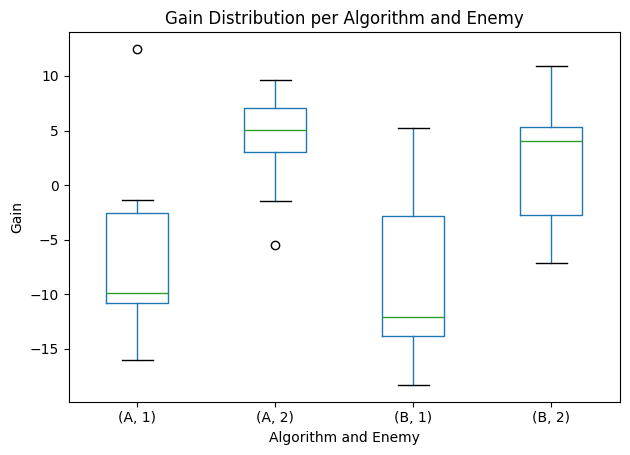

In [13]:
# Create a boxplot for the gains
plt.figure(figsize=(10, 6))
results_df.boxplot(column='Gain', by=['Algorithm', 'Enemy Group'], grid=False)

# Set plot labels and title
plt.title('Gain Distribution per Algorithm and Enemy')
plt.suptitle('') 
plt.xlabel('Algorithm and Enemy')
plt.ylabel('Gain')

# Display the plot
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

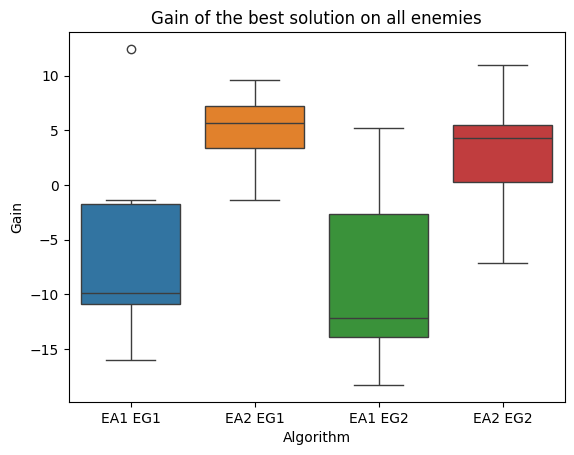

In [21]:
# make 2 boxplots of the gains
results = results_df['Gain'].tolist()
gains_EA1_EG1 = results[:9]
gains_EA2_EG1 = results[10:19]
gains_EA1_EG2 = results[20:29]
gains_EA2_EG2 = results[30:39]
plt.figure()
sns.boxplot(data=[gains_EA1_EG1, gains_EA2_EG1, gains_EA1_EG2, gains_EA2_EG2])	# add other solutions here 
plt.xlabel('Algorithm')
plt.ylabel('Gain')
plt.title('Gain of the best solution on all enemies')
plt.xticks([0, 1, 2, 3], ['EA1 EG1', 'EA2 EG1','EA1 EG2', 'EA2 EG2'])
plt.show()


# Statistical Tests

In [22]:
# Perform a t-test
t_statistic, p_value = ttest_ind(gains_EA1_EG1, gains_EA2_EG1)
print(f'T-statistic: {t_statistic:.4f}')
print(f'P-value: {p_value:.4f}')

# Perform a Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(gains_EA1_EG1, gains_EA2_EG1)
print(f'U-statistic: {u_statistic:.4f}')
print(f'P-value: {p_value:.4f}')


t_statistic, p_value = ttest_ind(gains_EA1_EG2, gains_EA2_EG2)
print(f'T-statistic: {t_statistic:.4f}')
print(f'P-value: {p_value:.4f}')

# Perform a Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(gains_EA1_EG2, gains_EA2_EG2)
print(f'U-statistic: {u_statistic:.4f}')
print(f'P-value: {p_value:.4f}')


T-statistic: -3.6982
P-value: 0.0019
U-statistic: 10.0000
P-value: 0.0081
T-statistic: -3.4233
P-value: 0.0035
U-statistic: 12.0000
P-value: 0.0134
